## Setup

In [1]:
import random
random.seed(2020)

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import sparse

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# Utilities 
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
    
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name+ ' (AUC = %0.3f)' % auc(fp, tp), linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
#     plt.xlim([-0.5,20])
#     plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
def AUCcalc(y_val_val, y_pred):
    fpr, tpr, thresholds = roc_curve(y_val_val, y_pred)
    tauc = auc(fpr, tpr)
    return tauc

## Data processing and exploration

In [8]:
full_preprocessed_train = pd.DataFrame(pd.read_csv(os.getcwd() + '/' + 'full_preprocessed_train.csv', sep=','))
full_preprocessed_val = pd.DataFrame(pd.read_csv(os.getcwd() + '/' + 'full_preprocessed_dev.csv', sep=','))

full_preprocessed_train = full_preprocessed_train.replace(np.nan, " ")
full_preprocessed_val = full_preprocessed_val.replace(np.nan, " ")

In [9]:
doc2vec_train = pd.DataFrame(pd.read_csv(os.getcwd() + '/' + 'dv_train.csv', sep=',', header=None))
doc2vec_val = pd.DataFrame(pd.read_csv(os.getcwd() + '/' + 'dv_val.csv', sep=',', header=None))

In [10]:
doc2vec_X_training_data = pd.concat([full_preprocessed_train, doc2vec_train], axis=1, sort=False)
doc2vec_X_val_data = pd.concat([full_preprocessed_val, doc2vec_val], axis=1, sort=False)

### Examine the class label imbalance

Let's look at the dataset imbalance:

In [11]:
neg, pos = np.bincount(doc2vec_X_training_data['label'])
total = neg + pos

### Clean and normalize the data

In [12]:
cleaned_train = doc2vec_X_training_data.copy()
cleaned_val = doc2vec_X_val_data.copy()

# You don't want the `Time` column.
cleaned_train = cleaned_train.drop(['date'], axis=1)
cleaned_val = cleaned_val.drop(['date'], axis=1)

# The `length` column covers a huge range. Convert to log-space.
eps=0.001 
cleaned_train['length'] = np.log(cleaned_train.pop('length')+eps)
cleaned_val['length'] = np.log(cleaned_val.pop('length')+eps)

In [13]:
# Can't normalize str col
cleaned_train = cleaned_train.drop(['review'], axis = 1)
cleaned_val = cleaned_val.drop(['review'], axis = 1)

In [14]:
train_df = cleaned_train.copy()
val_df = cleaned_val.copy()

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('label'))
val_labels = np.array(val_df.pop('label'))
# test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
# test_features = np.array(test_df)

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [15]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
# test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
# test_features = np.clip(test_features, -5, 5)


## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [16]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    # Sequential groups a linear stack of layers into a tf.keras.Model.
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [17]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [18]:
initial_bias = np.log([pos/neg])

In [19]:
model = make_model(output_bias = initial_bias)

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [20]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

### Train the model

## Class weights

### Calculate class weights

The goal is to identify fradulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [21]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

Weight for class 0: 0.56
Weight for class 1: 4.86


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `optimizers.SGD`, may fail. The optimizer used here, `optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [22]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
123/123 [==============================] - 2s 16ms/step - loss: 0.9820 - tp: 7457.0000 - fp: 37391.0000 - tn: 187664.0000 - fn: 18362.0000 - accuracy: 0.7778 - precision: 0.1663 - recall: 0.2888 - auc: 0.6175 - val_loss: 0.4373 - val_tp: 1241.0000 - val_fp: 4987.0000 - val_tn: 27283.0000 - val_fn: 2407.0000 - val_accuracy: 0.7941 - val_precision: 0.1993 - val_recall: 0.3402 - val_auc: 0.6792
Epoch 2/100
123/123 [==============================] - 1s 8ms/step - loss: 0.7732 - tp: 10568.0000 - fp: 51691.0000 - tn: 173364.0000 - fn: 15251.0000 - accuracy: 0.7332 - precision: 0.1697 - recall: 0.4093 - auc: 0.6482 - val_loss: 0.4480 - val_tp: 1436.0000 - val_fp: 5350.0000 - val_tn: 26920.0000 - val_fn: 2212.0000 - val_accuracy: 0.7895 - val_precision: 0.2116 - val_recall: 0.3936 - val_auc: 0.7141
Epoch 3/100
123/123 [==============================] - 1s 8ms/step - loss: 0.7122 - tp: 11984.0000 - fp: 55571.0000 - tn: 169484.0000 - fn: 13835.0000 - accuracy: 0.7233 - precision: 0.1

123/123 [==============================] - 1s 9ms/step - loss: 0.5927 - tp: 17514.0000 - fp: 72635.0000 - tn: 152420.0000 - fn: 8305.0000 - accuracy: 0.6774 - precision: 0.1943 - recall: 0.6783 - auc: 0.7443 - val_loss: 0.4314 - val_tp: 1325.0000 - val_fp: 4101.0000 - val_tn: 28169.0000 - val_fn: 2323.0000 - val_accuracy: 0.8211 - val_precision: 0.2442 - val_recall: 0.3632 - val_auc: 0.7522
Epoch 22/100
123/123 [==============================] - 1s 10ms/step - loss: 0.5924 - tp: 17479.0000 - fp: 72393.0000 - tn: 152662.0000 - fn: 8340.0000 - accuracy: 0.6782 - precision: 0.1945 - recall: 0.6770 - auc: 0.7444 - val_loss: 0.4321 - val_tp: 1356.0000 - val_fp: 4216.0000 - val_tn: 28054.0000 - val_fn: 2292.0000 - val_accuracy: 0.8188 - val_precision: 0.2434 - val_recall: 0.3717 - val_auc: 0.7523
Epoch 23/100
123/123 [==============================] - 1s 11ms/step - loss: 0.5905 - tp: 17714.0000 - fp: 73434.0000 - tn: 151621.0000 - fn: 8105.0000 - accuracy: 0.6750 - precision: 0.1943 - recal

### Check training history

### Evaluate metrics

In [24]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
val_predictions_weighted = weighted_model.predict(val_features, batch_size=BATCH_SIZE)

### Plot the ROC

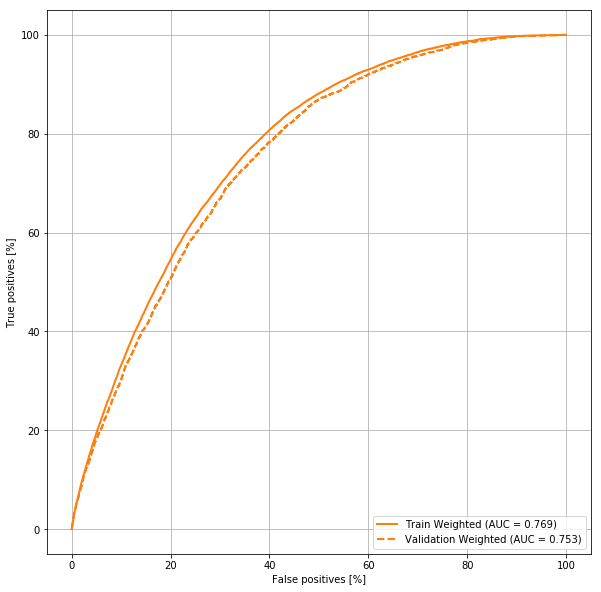

In [26]:
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Validation Weighted", val_labels, val_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

In [27]:
print("Average Precision Report:")
print("Validation Weighted: ", average_precision_score(val_labels, val_predictions_weighted))

Average Precision Report:
Validation Weighted:  0.23499379006955262


In [28]:
print("AUC:")
print("Validation Weighted: ", AUCcalc(val_labels, val_predictions_weighted))

AUC:
Validation Weighted:  0.7529670459704031


# Tuning

In [32]:
from itertools import product

In [47]:
def make_model(metrics = METRICS, lr = 1e-3, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    # Sequential groups a linear stack of layers into a tf.keras.Model.
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=lr),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [81]:
# BATCH_SIZE = [2000, 10000]
# EPOCHS = [100, 250, 500]
# lr  = [0.001, 0.01, 0.1, 1.0]
BATCH_SIZE = [2000, 10000]
EPOCHS = [100]
lr  = list(np.unique(np.concatenate((10.**np.arange(-6,1,1), np.arange(1,3,.3)))) )

every_cart = list(product(BATCH_SIZE, EPOCHS, lr))

In [69]:
saved_iterations = {}

for i, j, k in every_cart:       
    weighted_model = make_model(lr = k)
    weighted_model.load_weights(initial_weights)

    weighted_history = weighted_model.fit(
        train_features,
        train_labels,
        batch_size=i,
        epochs=j,
        callbacks = [early_stopping],
        validation_data=(val_features, val_labels),
        # The class weights go here
        class_weight=class_weight) 

    val_predictions_weighted = weighted_model.predict(val_features, batch_size=i)
    AP = average_precision_score(val_labels, val_predictions_weighted)
    AUC = AUCcalc(val_labels, val_predictions_weighted)
    
    saved_iterations[(i, j, k)] = [AP, AUC]


Epoch 1/100
126/126 [==============================] - 3s 22ms/step - loss: 0.9826 - tp: 8691.0000 - fp: 41089.0000 - tn: 216236.0000 - fn: 20776.0000 - accuracy: 0.7843 - precision: 0.1746 - recall: 0.2949 - auc: 0.6251 - val_loss: 0.4462 - val_tp: 1318.0000 - val_fp: 5458.0000 - val_tn: 26812.0000 - val_fn: 2330.0000 - val_accuracy: 0.7832 - val_precision: 0.1945 - val_recall: 0.3613 - val_auc: 0.6804
Epoch 2/100
126/126 [==============================] - 1s 9ms/step - loss: 0.7743 - tp: 10480.0000 - fp: 51748.0000 - tn: 173307.0000 - fn: 15339.0000 - accuracy: 0.7326 - precision: 0.1684 - recall: 0.4059 - auc: 0.6474 - val_loss: 0.4519 - val_tp: 1472.0000 - val_fp: 5606.0000 - val_tn: 26664.0000 - val_fn: 2176.0000 - val_accuracy: 0.7833 - val_precision: 0.2080 - val_recall: 0.4035 - val_auc: 0.7141
Epoch 3/100
126/126 [==============================] - 1s 9ms/step - loss: 0.7087 - tp: 12100.0000 - fp: 55788.0000 - tn: 169267.0000 - fn: 13719.0000 - accuracy: 0.7229 - precision: 0.1

126/126 [==============================] - 1s 8ms/step - loss: 0.5930 - tp: 17451.0000 - fp: 72092.0000 - tn: 152963.0000 - fn: 8368.0000 - accuracy: 0.6793 - precision: 0.1949 - recall: 0.6759 - auc: 0.7440 - val_loss: 0.4370 - val_tp: 1386.0000 - val_fp: 4359.0000 - val_tn: 27911.0000 - val_fn: 2262.0000 - val_accuracy: 0.8157 - val_precision: 0.2413 - val_recall: 0.3799 - val_auc: 0.7528
Epoch 22/100
126/126 [==============================] - 1s 11ms/step - loss: 0.5921 - tp: 17675.0000 - fp: 72963.0000 - tn: 152092.0000 - fn: 8144.0000 - accuracy: 0.6767 - precision: 0.1950 - recall: 0.6846 - auc: 0.7453 - val_loss: 0.4375 - val_tp: 1429.0000 - val_fp: 4574.0000 - val_tn: 27696.0000 - val_fn: 2219.0000 - val_accuracy: 0.8109 - val_precision: 0.2380 - val_recall: 0.3917 - val_auc: 0.7519
Epoch 23/100
126/126 [==============================] - 1s 8ms/step - loss: 0.5903 - tp: 17682.0000 - fp: 73409.0000 - tn: 151646.0000 - fn: 8137.0000 - accuracy: 0.6750 - precision: 0.1941 - recall

126/126 [==============================] - 2s 14ms/step - loss: 0.6811 - tp: 16965.0000 - fp: 79743.0000 - tn: 177582.0000 - fn: 12502.0000 - accuracy: 0.6784 - precision: 0.1754 - recall: 0.5757 - auc: 0.6860 - val_loss: 0.6060 - val_tp: 2719.0000 - val_fp: 11739.0000 - val_tn: 20531.0000 - val_fn: 929.0000 - val_accuracy: 0.6473 - val_precision: 0.1881 - val_recall: 0.7453 - val_auc: 0.7489
Epoch 2/100
126/126 [==============================] - 1s 8ms/step - loss: 0.6130 - tp: 18093.0000 - fp: 81273.0000 - tn: 143782.0000 - fn: 7726.0000 - accuracy: 0.6452 - precision: 0.1821 - recall: 0.7008 - auc: 0.7257 - val_loss: 0.4945 - val_tp: 1975.0000 - val_fp: 7395.0000 - val_tn: 24875.0000 - val_fn: 1673.0000 - val_accuracy: 0.7475 - val_precision: 0.2108 - val_recall: 0.5414 - val_auc: 0.7409
Epoch 3/100
126/126 [==============================] - 1s 8ms/step - loss: 0.6150 - tp: 18088.0000 - fp: 80749.0000 - tn: 144306.0000 - fn: 7731.0000 - accuracy: 0.6473 - precision: 0.1830 - recall:

126/126 [==============================] - 1s 8ms/step - loss: 0.7081 - tp: 21042.0000 - fp: 161253.0000 - tn: 63802.0000 - fn: 4777.0000 - accuracy: 0.3382 - precision: 0.1154 - recall: 0.8150 - auc: 0.5609 - val_loss: 0.6909 - val_tp: 3374.0000 - val_fp: 24071.0000 - val_tn: 8199.0000 - val_fn: 274.0000 - val_accuracy: 0.3222 - val_precision: 0.1229 - val_recall: 0.9249 - val_auc: 0.5914
Epoch 11/100
126/126 [==============================] - 1s 8ms/step - loss: 0.7158 - tp: 20263.0000 - fp: 162515.0000 - tn: 62540.0000 - fn: 5556.0000 - accuracy: 0.3301 - precision: 0.1109 - recall: 0.7848 - auc: 0.5369 - val_loss: 0.6189 - val_tp: 44.0000 - val_fp: 98.0000 - val_tn: 32172.0000 - val_fn: 3604.0000 - val_accuracy: 0.8969 - val_precision: 0.3099 - val_recall: 0.0121 - val_auc: 0.5614
Epoch 12/100
126/126 [==============================] - 1s 8ms/step - loss: 0.7475 - tp: 15805.0000 - fp: 128027.0000 - tn: 97028.0000 - fn: 10014.0000 - accuracy: 0.4498 - precision: 0.1099 - recall: 0.6

126/126 [==============================] - 1s 8ms/step - loss: 0.5981 - tp: 16879.0000 - fp: 70328.0000 - tn: 154727.0000 - fn: 8940.0000 - accuracy: 0.6840 - precision: 0.1936 - recall: 0.6537 - auc: 0.7401 - val_loss: 0.4426 - val_tp: 1551.0000 - val_fp: 5093.0000 - val_tn: 27177.0000 - val_fn: 2097.0000 - val_accuracy: 0.7998 - val_precision: 0.2334 - val_recall: 0.4252 - val_auc: 0.7530
Epoch 18/250
126/126 [==============================] - 1s 8ms/step - loss: 0.5976 - tp: 16970.0000 - fp: 71166.0000 - tn: 153889.0000 - fn: 8849.0000 - accuracy: 0.6811 - precision: 0.1925 - recall: 0.6573 - auc: 0.7398 - val_loss: 0.4334 - val_tp: 1437.0000 - val_fp: 4531.0000 - val_tn: 27739.0000 - val_fn: 2211.0000 - val_accuracy: 0.8123 - val_precision: 0.2408 - val_recall: 0.3939 - val_auc: 0.7525
Epoch 19/250
126/126 [==============================] - 1s 8ms/step - loss: 0.5948 - tp: 17234.0000 - fp: 71451.0000 - tn: 153604.0000 - fn: 8585.0000 - accuracy: 0.6810 - precision: 0.1943 - recall:

126/126 [==============================] - 1s 10ms/step - loss: 0.5882 - tp: 19029.0000 - fp: 79724.0000 - tn: 145331.0000 - fn: 6790.0000 - accuracy: 0.6551 - precision: 0.1927 - recall: 0.7370 - auc: 0.7505 - val_loss: 0.4394 - val_tp: 802.0000 - val_fp: 2021.0000 - val_tn: 30249.0000 - val_fn: 2846.0000 - val_accuracy: 0.8645 - val_precision: 0.2841 - val_recall: 0.2198 - val_auc: 0.7465
Epoch 9/250
126/126 [==============================] - 1s 8ms/step - loss: 0.5873 - tp: 18964.0000 - fp: 78281.0000 - tn: 146774.0000 - fn: 6855.0000 - accuracy: 0.6606 - precision: 0.1950 - recall: 0.7345 - auc: 0.7521 - val_loss: 0.4355 - val_tp: 1191.0000 - val_fp: 3555.0000 - val_tn: 28715.0000 - val_fn: 2457.0000 - val_accuracy: 0.8326 - val_precision: 0.2509 - val_recall: 0.3265 - val_auc: 0.7478
Epoch 10/250
126/126 [==============================] - 1s 8ms/step - loss: 0.5867 - tp: 18986.0000 - fp: 78648.0000 - tn: 146407.0000 - fn: 6833.0000 - accuracy: 0.6593 - precision: 0.1945 - recall: 

126/126 [==============================] - 1s 8ms/step - loss: 0.7155 - tp: 23188.0000 - fp: 154957.0000 - tn: 70098.0000 - fn: 2631.0000 - accuracy: 0.3718 - precision: 0.1302 - recall: 0.8981 - auc: 0.6051 - val_loss: 0.5779 - val_tp: 3135.0000 - val_fp: 18328.0000 - val_tn: 13942.0000 - val_fn: 513.0000 - val_accuracy: 0.4754 - val_precision: 0.1461 - val_recall: 0.8594 - val_auc: 0.6654
Epoch 3/250
126/126 [==============================] - 1s 8ms/step - loss: 0.6796 - tp: 23598.0000 - fp: 159733.0000 - tn: 65322.0000 - fn: 2221.0000 - accuracy: 0.3544 - precision: 0.1287 - recall: 0.9140 - auc: 0.6073 - val_loss: 0.6793 - val_tp: 3288.0000 - val_fp: 20579.0000 - val_tn: 11691.0000 - val_fn: 360.0000 - val_accuracy: 0.4170 - val_precision: 0.1378 - val_recall: 0.9013 - val_auc: 0.6734
Epoch 4/250
126/126 [==============================] - 1s 8ms/step - loss: 0.6729 - tp: 23864.0000 - fp: 159392.0000 - tn: 65663.0000 - fn: 1955.0000 - accuracy: 0.3569 - precision: 0.1302 - recall: 0

126/126 [==============================] - 1s 9ms/step - loss: 0.6302 - tp: 15110.0000 - fp: 63807.0000 - tn: 161248.0000 - fn: 10709.0000 - accuracy: 0.7030 - precision: 0.1915 - recall: 0.5852 - auc: 0.7195 - val_loss: 0.4420 - val_tp: 1604.0000 - val_fp: 5354.0000 - val_tn: 26916.0000 - val_fn: 2044.0000 - val_accuracy: 0.7940 - val_precision: 0.2305 - val_recall: 0.4397 - val_auc: 0.7499
Epoch 9/500
126/126 [==============================] - 1s 9ms/step - loss: 0.6251 - tp: 15236.0000 - fp: 64686.0000 - tn: 160369.0000 - fn: 10583.0000 - accuracy: 0.7000 - precision: 0.1906 - recall: 0.5901 - auc: 0.7218 - val_loss: 0.4510 - val_tp: 1679.0000 - val_fp: 5710.0000 - val_tn: 26560.0000 - val_fn: 1969.0000 - val_accuracy: 0.7862 - val_precision: 0.2272 - val_recall: 0.4603 - val_auc: 0.7506
Epoch 10/500
126/126 [==============================] - 1s 9ms/step - loss: 0.6183 - tp: 15575.0000 - fp: 65531.0000 - tn: 159524.0000 - fn: 10244.0000 - accuracy: 0.6980 - precision: 0.1920 - recal

126/126 [==============================] - 1s 8ms/step - loss: 0.5854 - tp: 18430.0000 - fp: 76100.0000 - tn: 148955.0000 - fn: 7389.0000 - accuracy: 0.6672 - precision: 0.1950 - recall: 0.7138 - auc: 0.7519 - val_loss: 0.4270 - val_tp: 1116.0000 - val_fp: 3232.0000 - val_tn: 29038.0000 - val_fn: 2532.0000 - val_accuracy: 0.8395 - val_precision: 0.2567 - val_recall: 0.3059 - val_auc: 0.7494
Epoch 29/500
126/126 [==============================] - 1s 8ms/step - loss: 0.5848 - tp: 18493.0000 - fp: 75875.0000 - tn: 149180.0000 - fn: 7326.0000 - accuracy: 0.6684 - precision: 0.1960 - recall: 0.7163 - auc: 0.7525 - val_loss: 0.4277 - val_tp: 1060.0000 - val_fp: 2990.0000 - val_tn: 29280.0000 - val_fn: 2588.0000 - val_accuracy: 0.8447 - val_precision: 0.2617 - val_recall: 0.2906 - val_auc: 0.7482
Epoch 1/500
126/126 [==============================] - 2s 14ms/step - loss: 0.7148 - tp: 13881.0000 - fp: 61646.0000 - tn: 195679.0000 - fn: 15586.0000 - accuracy: 0.7307 - precision: 0.1838 - recall

126/126 [==============================] - 1s 8ms/step - loss: 0.6144 - tp: 17764.0000 - fp: 78377.0000 - tn: 146678.0000 - fn: 8055.0000 - accuracy: 0.6555 - precision: 0.1848 - recall: 0.6880 - auc: 0.7268 - val_loss: 0.4704 - val_tp: 1370.0000 - val_fp: 4524.0000 - val_tn: 27746.0000 - val_fn: 2278.0000 - val_accuracy: 0.8106 - val_precision: 0.2324 - val_recall: 0.3755 - val_auc: 0.7354
Epoch 7/500
126/126 [==============================] - 1s 8ms/step - loss: 0.6210 - tp: 17398.0000 - fp: 78520.0000 - tn: 146535.0000 - fn: 8421.0000 - accuracy: 0.6534 - precision: 0.1814 - recall: 0.6738 - auc: 0.7210 - val_loss: 0.4914 - val_tp: 1800.0000 - val_fp: 6710.0000 - val_tn: 25560.0000 - val_fn: 1848.0000 - val_accuracy: 0.7617 - val_precision: 0.2115 - val_recall: 0.4934 - val_auc: 0.7363
Epoch 8/500
126/126 [==============================] - 1s 8ms/step - loss: 0.6179 - tp: 17351.0000 - fp: 76493.0000 - tn: 148562.0000 - fn: 8468.0000 - accuracy: 0.6613 - precision: 0.1849 - recall: 0

126/126 [==============================] - 1s 8ms/step - loss: 0.7019 - tp: 14284.0000 - fp: 119346.0000 - tn: 105709.0000 - fn: 11535.0000 - accuracy: 0.4783 - precision: 0.1069 - recall: 0.5532 - auc: 0.5197 - val_loss: 0.6400 - val_tp: 29.0000 - val_fp: 88.0000 - val_tn: 32182.0000 - val_fn: 3619.0000 - val_accuracy: 0.8968 - val_precision: 0.2479 - val_recall: 0.0079 - val_auc: 0.5309
Epoch 16/500
126/126 [==============================] - 1s 8ms/step - loss: 0.7267 - tp: 14443.0000 - fp: 122910.0000 - tn: 102145.0000 - fn: 11376.0000 - accuracy: 0.4647 - precision: 0.1052 - recall: 0.5594 - auc: 0.5156 - val_loss: 0.6837 - val_tp: 3601.0000 - val_fp: 30158.0000 - val_tn: 2112.0000 - val_fn: 47.0000 - val_accuracy: 0.1591 - val_precision: 0.1067 - val_recall: 0.9871 - val_auc: 0.5274
Epoch 1/100
26/26 [==============================] - 2s 66ms/step - loss: 1.2268 - tp: 6361.0000 - fp: 43463.0000 - tn: 213862.0000 - fn: 23106.0000 - accuracy: 0.7679 - precision: 0.1277 - recall: 0.2

26/26 [==============================] - 1s 36ms/step - loss: 0.6624 - tp: 13428.0000 - fp: 58075.0000 - tn: 166980.0000 - fn: 12391.0000 - accuracy: 0.7191 - precision: 0.1878 - recall: 0.5201 - auc: 0.7033 - val_loss: 0.4448 - val_tp: 1630.0000 - val_fp: 5609.0000 - val_tn: 26661.0000 - val_fn: 2018.0000 - val_accuracy: 0.7877 - val_precision: 0.2252 - val_recall: 0.4468 - val_auc: 0.7438
Epoch 20/100
26/26 [==============================] - 1s 35ms/step - loss: 0.6579 - tp: 13707.0000 - fp: 58755.0000 - tn: 166300.0000 - fn: 12112.0000 - accuracy: 0.7175 - precision: 0.1892 - recall: 0.5309 - auc: 0.7070 - val_loss: 0.4413 - val_tp: 1603.0000 - val_fp: 5399.0000 - val_tn: 26871.0000 - val_fn: 2045.0000 - val_accuracy: 0.7928 - val_precision: 0.2289 - val_recall: 0.4394 - val_auc: 0.7452
Epoch 21/100
26/26 [==============================] - 1s 34ms/step - loss: 0.6584 - tp: 13647.0000 - fp: 58792.0000 - tn: 166263.0000 - fn: 12172.0000 - accuracy: 0.7171 - precision: 0.1884 - recall:

26/26 [==============================] - 1s 35ms/step - loss: 0.6252 - tp: 15079.0000 - fp: 63337.0000 - tn: 161718.0000 - fn: 10740.0000 - accuracy: 0.7047 - precision: 0.1923 - recall: 0.5840 - auc: 0.7252 - val_loss: 0.4327 - val_tp: 1560.0000 - val_fp: 5104.0000 - val_tn: 27166.0000 - val_fn: 2088.0000 - val_accuracy: 0.7998 - val_precision: 0.2341 - val_recall: 0.4276 - val_auc: 0.7527
Epoch 40/100
26/26 [==============================] - 1s 36ms/step - loss: 0.6242 - tp: 15034.0000 - fp: 63232.0000 - tn: 161823.0000 - fn: 10785.0000 - accuracy: 0.7050 - precision: 0.1921 - recall: 0.5823 - auc: 0.7254 - val_loss: 0.4267 - val_tp: 1497.0000 - val_fp: 4785.0000 - val_tn: 27485.0000 - val_fn: 2151.0000 - val_accuracy: 0.8069 - val_precision: 0.2383 - val_recall: 0.4104 - val_auc: 0.7530
Epoch 41/100
26/26 [==============================] - 1s 36ms/step - loss: 0.6209 - tp: 15226.0000 - fp: 63147.0000 - tn: 161908.0000 - fn: 10593.0000 - accuracy: 0.7061 - precision: 0.1943 - recall:

26/26 [==============================] - 1s 34ms/step - loss: 0.6055 - tp: 15991.0000 - fp: 66537.0000 - tn: 158518.0000 - fn: 9828.0000 - accuracy: 0.6956 - precision: 0.1938 - recall: 0.6194 - auc: 0.7359 - val_loss: 0.4243 - val_tp: 1382.0000 - val_fp: 4298.0000 - val_tn: 27972.0000 - val_fn: 2266.0000 - val_accuracy: 0.8173 - val_precision: 0.2433 - val_recall: 0.3788 - val_auc: 0.7536
Epoch 60/100
26/26 [==============================] - 1s 35ms/step - loss: 0.6051 - tp: 16225.0000 - fp: 67193.0000 - tn: 157862.0000 - fn: 9594.0000 - accuracy: 0.6939 - precision: 0.1945 - recall: 0.6284 - auc: 0.7362 - val_loss: 0.4218 - val_tp: 1352.0000 - val_fp: 4184.0000 - val_tn: 28086.0000 - val_fn: 2296.0000 - val_accuracy: 0.8196 - val_precision: 0.2442 - val_recall: 0.3706 - val_auc: 0.7535
Epoch 61/100
26/26 [==============================] - 1s 34ms/step - loss: 0.6039 - tp: 16364.0000 - fp: 68092.0000 - tn: 156963.0000 - fn: 9455.0000 - accuracy: 0.6909 - precision: 0.1938 - recall: 0.

26/26 [==============================] - 1s 34ms/step - loss: 0.5871 - tp: 18531.0000 - fp: 76709.0000 - tn: 148346.0000 - fn: 7288.0000 - accuracy: 0.6652 - precision: 0.1946 - recall: 0.7177 - auc: 0.7504 - val_loss: 0.4355 - val_tp: 1211.0000 - val_fp: 3561.0000 - val_tn: 28709.0000 - val_fn: 2437.0000 - val_accuracy: 0.8330 - val_precision: 0.2538 - val_recall: 0.3320 - val_auc: 0.7502
Epoch 19/100
26/26 [==============================] - 1s 34ms/step - loss: 0.5877 - tp: 18710.0000 - fp: 77907.0000 - tn: 147148.0000 - fn: 7109.0000 - accuracy: 0.6611 - precision: 0.1937 - recall: 0.7247 - auc: 0.7500 - val_loss: 0.4360 - val_tp: 1205.0000 - val_fp: 3545.0000 - val_tn: 28725.0000 - val_fn: 2443.0000 - val_accuracy: 0.8333 - val_precision: 0.2537 - val_recall: 0.3303 - val_auc: 0.7509
Epoch 20/100
26/26 [==============================] - 1s 35ms/step - loss: 0.5859 - tp: 18751.0000 - fp: 77592.0000 - tn: 147463.0000 - fn: 7068.0000 - accuracy: 0.6625 - precision: 0.1946 - recall: 0.

26/26 [==============================] - 1s 34ms/step - loss: 0.5940 - tp: 18848.0000 - fp: 79878.0000 - tn: 145177.0000 - fn: 6971.0000 - accuracy: 0.6538 - precision: 0.1909 - recall: 0.7300 - auc: 0.7458 - val_loss: 0.4558 - val_tp: 1392.0000 - val_fp: 4444.0000 - val_tn: 27826.0000 - val_fn: 2256.0000 - val_accuracy: 0.8135 - val_precision: 0.2385 - val_recall: 0.3816 - val_auc: 0.7437
Epoch 16/100
26/26 [==============================] - 1s 34ms/step - loss: 0.5931 - tp: 18763.0000 - fp: 78752.0000 - tn: 146303.0000 - fn: 7056.0000 - accuracy: 0.6580 - precision: 0.1924 - recall: 0.7267 - auc: 0.7470 - val_loss: 0.4806 - val_tp: 1882.0000 - val_fp: 6729.0000 - val_tn: 25541.0000 - val_fn: 1766.0000 - val_accuracy: 0.7635 - val_precision: 0.2186 - val_recall: 0.5159 - val_auc: 0.7462
Epoch 17/100
26/26 [==============================] - 1s 34ms/step - loss: 0.5924 - tp: 18906.0000 - fp: 79370.0000 - tn: 145685.0000 - fn: 6913.0000 - accuracy: 0.6561 - precision: 0.1924 - recall: 0.

26/26 [==============================] - 1s 34ms/step - loss: 0.6421 - tp: 23876.0000 - fp: 148090.0000 - tn: 76965.0000 - fn: 1943.0000 - accuracy: 0.4020 - precision: 0.1388 - recall: 0.9247 - auc: 0.6520 - val_loss: 0.6004 - val_tp: 3154.0000 - val_fp: 17738.0000 - val_tn: 14532.0000 - val_fn: 494.0000 - val_accuracy: 0.4924 - val_precision: 0.1510 - val_recall: 0.8646 - val_auc: 0.6848
Epoch 15/100
26/26 [==============================] - 1s 34ms/step - loss: 0.6454 - tp: 23840.0000 - fp: 147947.0000 - tn: 77108.0000 - fn: 1979.0000 - accuracy: 0.4024 - precision: 0.1388 - recall: 0.9234 - auc: 0.6494 - val_loss: 0.5493 - val_tp: 3049.0000 - val_fp: 15986.0000 - val_tn: 16284.0000 - val_fn: 599.0000 - val_accuracy: 0.5383 - val_precision: 0.1602 - val_recall: 0.8358 - val_auc: 0.7017
Epoch 16/100
26/26 [==============================] - 1s 35ms/step - loss: 0.6400 - tp: 23763.0000 - fp: 145861.0000 - tn: 79194.0000 - fn: 2056.0000 - accuracy: 0.4104 - precision: 0.1401 - recall: 0.

26/26 [==============================] - 1s 33ms/step - loss: 0.7875 - tp: 10099.0000 - fp: 49971.0000 - tn: 175084.0000 - fn: 15720.0000 - accuracy: 0.7382 - precision: 0.1681 - recall: 0.3911 - auc: 0.6424 - val_loss: 0.4442 - val_tp: 1353.0000 - val_fp: 5295.0000 - val_tn: 26975.0000 - val_fn: 2295.0000 - val_accuracy: 0.7887 - val_precision: 0.2035 - val_recall: 0.3709 - val_auc: 0.6966
Epoch 7/250
26/26 [==============================] - 1s 33ms/step - loss: 0.7669 - tp: 10391.0000 - fp: 50759.0000 - tn: 174296.0000 - fn: 15428.0000 - accuracy: 0.7362 - precision: 0.1699 - recall: 0.4025 - auc: 0.6502 - val_loss: 0.4448 - val_tp: 1397.0000 - val_fp: 5289.0000 - val_tn: 26981.0000 - val_fn: 2251.0000 - val_accuracy: 0.7901 - val_precision: 0.2089 - val_recall: 0.3829 - val_auc: 0.7049
Epoch 8/250
26/26 [==============================] - 1s 34ms/step - loss: 0.7464 - tp: 10965.0000 - fp: 52279.0000 - tn: 172776.0000 - fn: 14854.0000 - accuracy: 0.7324 - precision: 0.1734 - recall: 0

26/26 [==============================] - 1s 35ms/step - loss: 0.6444 - tp: 14159.0000 - fp: 60383.0000 - tn: 164672.0000 - fn: 11660.0000 - accuracy: 0.7128 - precision: 0.1899 - recall: 0.5484 - auc: 0.7145 - val_loss: 0.4347 - val_tp: 1577.0000 - val_fp: 5212.0000 - val_tn: 27058.0000 - val_fn: 2071.0000 - val_accuracy: 0.7972 - val_precision: 0.2323 - val_recall: 0.4323 - val_auc: 0.7491
Epoch 27/250
26/26 [==============================] - 1s 33ms/step - loss: 0.6421 - tp: 14272.0000 - fp: 60222.0000 - tn: 164833.0000 - fn: 11547.0000 - accuracy: 0.7139 - precision: 0.1916 - recall: 0.5528 - auc: 0.7161 - val_loss: 0.4348 - val_tp: 1580.0000 - val_fp: 5209.0000 - val_tn: 27061.0000 - val_fn: 2068.0000 - val_accuracy: 0.7974 - val_precision: 0.2327 - val_recall: 0.4331 - val_auc: 0.7498
Epoch 28/250
26/26 [==============================] - 1s 33ms/step - loss: 0.6408 - tp: 14307.0000 - fp: 60753.0000 - tn: 164302.0000 - fn: 11512.0000 - accuracy: 0.7119 - precision: 0.1906 - recall:

26/26 [==============================] - 1s 33ms/step - loss: 0.6166 - tp: 15253.0000 - fp: 63110.0000 - tn: 161945.0000 - fn: 10566.0000 - accuracy: 0.7063 - precision: 0.1946 - recall: 0.5908 - auc: 0.7305 - val_loss: 0.4280 - val_tp: 1505.0000 - val_fp: 4850.0000 - val_tn: 27420.0000 - val_fn: 2143.0000 - val_accuracy: 0.8053 - val_precision: 0.2368 - val_recall: 0.4126 - val_auc: 0.7528
Epoch 47/250
26/26 [==============================] - 1s 33ms/step - loss: 0.6157 - tp: 15530.0000 - fp: 64518.0000 - tn: 160537.0000 - fn: 10289.0000 - accuracy: 0.7018 - precision: 0.1940 - recall: 0.6015 - auc: 0.7310 - val_loss: 0.4259 - val_tp: 1481.0000 - val_fp: 4736.0000 - val_tn: 27534.0000 - val_fn: 2167.0000 - val_accuracy: 0.8078 - val_precision: 0.2382 - val_recall: 0.4060 - val_auc: 0.7530
Epoch 48/250
26/26 [==============================] - 1s 34ms/step - loss: 0.6158 - tp: 15368.0000 - fp: 64049.0000 - tn: 161006.0000 - fn: 10451.0000 - accuracy: 0.7030 - precision: 0.1935 - recall:

26/26 [==============================] - 2s 66ms/step - loss: 0.9033 - tp: 10656.0000 - fp: 52064.0000 - tn: 205261.0000 - fn: 18811.0000 - accuracy: 0.7529 - precision: 0.1699 - recall: 0.3616 - auc: 0.6328 - val_loss: 0.4847 - val_tp: 1715.0000 - val_fp: 7026.0000 - val_tn: 25244.0000 - val_fn: 1933.0000 - val_accuracy: 0.7506 - val_precision: 0.1962 - val_recall: 0.4701 - val_auc: 0.7117
Epoch 2/250
26/26 [==============================] - 1s 35ms/step - loss: 0.6965 - tp: 12195.0000 - fp: 56127.0000 - tn: 168928.0000 - fn: 13624.0000 - accuracy: 0.7220 - precision: 0.1785 - recall: 0.4723 - auc: 0.6788 - val_loss: 0.4724 - val_tp: 1786.0000 - val_fp: 6530.0000 - val_tn: 25740.0000 - val_fn: 1862.0000 - val_accuracy: 0.7664 - val_precision: 0.2148 - val_recall: 0.4896 - val_auc: 0.7376
Epoch 3/250
26/26 [==============================] - 1s 35ms/step - loss: 0.6525 - tp: 13798.0000 - fp: 59137.0000 - tn: 165918.0000 - fn: 12021.0000 - accuracy: 0.7164 - precision: 0.1892 - recall: 0

26/26 [==============================] - 1s 35ms/step - loss: 0.6046 - tp: 18366.0000 - fp: 81499.0000 - tn: 143556.0000 - fn: 7453.0000 - accuracy: 0.6454 - precision: 0.1839 - recall: 0.7113 - auc: 0.7323 - val_loss: 0.4821 - val_tp: 2003.0000 - val_fp: 7336.0000 - val_tn: 24934.0000 - val_fn: 1645.0000 - val_accuracy: 0.7500 - val_precision: 0.2145 - val_recall: 0.5491 - val_auc: 0.7458
Epoch 4/250
26/26 [==============================] - 1s 34ms/step - loss: 0.6023 - tp: 18137.0000 - fp: 79346.0000 - tn: 145709.0000 - fn: 7682.0000 - accuracy: 0.6531 - precision: 0.1861 - recall: 0.7025 - auc: 0.7348 - val_loss: 0.5430 - val_tp: 2405.0000 - val_fp: 9536.0000 - val_tn: 22734.0000 - val_fn: 1243.0000 - val_accuracy: 0.6999 - val_precision: 0.2014 - val_recall: 0.6593 - val_auc: 0.7487
Epoch 5/250
26/26 [==============================] - 1s 34ms/step - loss: 0.5981 - tp: 18458.0000 - fp: 79866.0000 - tn: 145189.0000 - fn: 7361.0000 - accuracy: 0.6523 - precision: 0.1877 - recall: 0.71

26/26 [==============================] - 1s 34ms/step - loss: 0.8394 - tp: 20242.0000 - fp: 136156.0000 - tn: 88899.0000 - fn: 5577.0000 - accuracy: 0.4350 - precision: 0.1294 - recall: 0.7840 - auc: 0.6022 - val_loss: 0.5240 - val_tp: 2901.0000 - val_fp: 15641.0000 - val_tn: 16629.0000 - val_fn: 747.0000 - val_accuracy: 0.5437 - val_precision: 0.1565 - val_recall: 0.7952 - val_auc: 0.6737
Epoch 7/250
26/26 [==============================] - 1s 34ms/step - loss: 0.6700 - tp: 23179.0000 - fp: 154315.0000 - tn: 70740.0000 - fn: 2640.0000 - accuracy: 0.3744 - precision: 0.1306 - recall: 0.8977 - auc: 0.6158 - val_loss: 0.6459 - val_tp: 3360.0000 - val_fp: 21593.0000 - val_tn: 10677.0000 - val_fn: 288.0000 - val_accuracy: 0.3908 - val_precision: 0.1347 - val_recall: 0.9211 - val_auc: 0.6428
Epoch 8/250
26/26 [==============================] - 1s 34ms/step - loss: 0.6521 - tp: 24307.0000 - fp: 160379.0000 - tn: 64676.0000 - fn: 1512.0000 - accuracy: 0.3547 - precision: 0.1316 - recall: 0.94

26/26 [==============================] - 1s 34ms/step - loss: 0.6325 - tp: 23271.0000 - fp: 138441.0000 - tn: 86614.0000 - fn: 2548.0000 - accuracy: 0.4380 - precision: 0.1439 - recall: 0.9013 - auc: 0.6690 - val_loss: 0.5706 - val_tp: 3041.0000 - val_fp: 16338.0000 - val_tn: 15932.0000 - val_fn: 607.0000 - val_accuracy: 0.5282 - val_precision: 0.1569 - val_recall: 0.8336 - val_auc: 0.6998
Epoch 27/250
26/26 [==============================] - 1s 33ms/step - loss: 0.6356 - tp: 23187.0000 - fp: 138496.0000 - tn: 86559.0000 - fn: 2632.0000 - accuracy: 0.4375 - precision: 0.1434 - recall: 0.8981 - auc: 0.6674 - val_loss: 0.5146 - val_tp: 2817.0000 - val_fp: 14432.0000 - val_tn: 17838.0000 - val_fn: 831.0000 - val_accuracy: 0.5751 - val_precision: 0.1633 - val_recall: 0.7722 - val_auc: 0.6943
Epoch 28/250
26/26 [==============================] - 1s 34ms/step - loss: 0.6343 - tp: 23141.0000 - fp: 137624.0000 - tn: 87431.0000 - fn: 2678.0000 - accuracy: 0.4407 - precision: 0.1439 - recall: 0.

26/26 [==============================] - 1s 35ms/step - loss: 0.8100 - tp: 9820.0000 - fp: 49210.0000 - tn: 175845.0000 - fn: 15999.0000 - accuracy: 0.7401 - precision: 0.1664 - recall: 0.3803 - auc: 0.6370 - val_loss: 0.4449 - val_tp: 1327.0000 - val_fp: 5347.0000 - val_tn: 26923.0000 - val_fn: 2321.0000 - val_accuracy: 0.7865 - val_precision: 0.1988 - val_recall: 0.3638 - val_auc: 0.6871
Epoch 6/500
26/26 [==============================] - 1s 33ms/step - loss: 0.7865 - tp: 10021.0000 - fp: 50262.0000 - tn: 174793.0000 - fn: 15798.0000 - accuracy: 0.7367 - precision: 0.1662 - recall: 0.3881 - auc: 0.6421 - val_loss: 0.4471 - val_tp: 1380.0000 - val_fp: 5429.0000 - val_tn: 26841.0000 - val_fn: 2268.0000 - val_accuracy: 0.7857 - val_precision: 0.2027 - val_recall: 0.3783 - val_auc: 0.6960
Epoch 7/500
26/26 [==============================] - 1s 33ms/step - loss: 0.7663 - tp: 10517.0000 - fp: 50874.0000 - tn: 174181.0000 - fn: 15302.0000 - accuracy: 0.7362 - precision: 0.1713 - recall: 0.

26/26 [==============================] - 1s 34ms/step - loss: 0.6445 - tp: 14291.0000 - fp: 60279.0000 - tn: 164776.0000 - fn: 11528.0000 - accuracy: 0.7138 - precision: 0.1916 - recall: 0.5535 - auc: 0.7150 - val_loss: 0.4413 - val_tp: 1628.0000 - val_fp: 5538.0000 - val_tn: 26732.0000 - val_fn: 2020.0000 - val_accuracy: 0.7896 - val_precision: 0.2272 - val_recall: 0.4463 - val_auc: 0.7483
Epoch 26/500
26/26 [==============================] - 1s 35ms/step - loss: 0.6427 - tp: 14224.0000 - fp: 59817.0000 - tn: 165238.0000 - fn: 11595.0000 - accuracy: 0.7153 - precision: 0.1921 - recall: 0.5509 - auc: 0.7162 - val_loss: 0.4361 - val_tp: 1601.0000 - val_fp: 5328.0000 - val_tn: 26942.0000 - val_fn: 2047.0000 - val_accuracy: 0.7947 - val_precision: 0.2311 - val_recall: 0.4389 - val_auc: 0.7491
Epoch 27/500
26/26 [==============================] - 1s 40ms/step - loss: 0.6427 - tp: 14211.0000 - fp: 60026.0000 - tn: 165029.0000 - fn: 11608.0000 - accuracy: 0.7145 - precision: 0.1914 - recall:

26/26 [==============================] - 1s 35ms/step - loss: 0.6179 - tp: 15365.0000 - fp: 64231.0000 - tn: 160824.0000 - fn: 10454.0000 - accuracy: 0.7023 - precision: 0.1930 - recall: 0.5951 - auc: 0.7293 - val_loss: 0.4253 - val_tp: 1467.0000 - val_fp: 4650.0000 - val_tn: 27620.0000 - val_fn: 2181.0000 - val_accuracy: 0.8098 - val_precision: 0.2398 - val_recall: 0.4021 - val_auc: 0.7535
Epoch 46/500
26/26 [==============================] - 1s 36ms/step - loss: 0.6183 - tp: 15372.0000 - fp: 63800.0000 - tn: 161255.0000 - fn: 10447.0000 - accuracy: 0.7040 - precision: 0.1942 - recall: 0.5954 - auc: 0.7287 - val_loss: 0.4290 - val_tp: 1517.0000 - val_fp: 4923.0000 - val_tn: 27347.0000 - val_fn: 2131.0000 - val_accuracy: 0.8036 - val_precision: 0.2356 - val_recall: 0.4158 - val_auc: 0.7528
Epoch 47/500
26/26 [==============================] - 1s 35ms/step - loss: 0.6145 - tp: 15500.0000 - fp: 64313.0000 - tn: 160742.0000 - fn: 10319.0000 - accuracy: 0.7025 - precision: 0.1942 - recall:

26/26 [==============================] - 2s 67ms/step - loss: 0.9007 - tp: 10688.0000 - fp: 51905.0000 - tn: 205420.0000 - fn: 18779.0000 - accuracy: 0.7535 - precision: 0.1708 - recall: 0.3627 - auc: 0.6327 - val_loss: 0.4703 - val_tp: 1573.0000 - val_fp: 6161.0000 - val_tn: 26109.0000 - val_fn: 2075.0000 - val_accuracy: 0.7707 - val_precision: 0.2034 - val_recall: 0.4312 - val_auc: 0.7138
Epoch 2/500
26/26 [==============================] - 1s 36ms/step - loss: 0.6953 - tp: 12345.0000 - fp: 56410.0000 - tn: 168645.0000 - fn: 13474.0000 - accuracy: 0.7214 - precision: 0.1796 - recall: 0.4781 - auc: 0.6808 - val_loss: 0.4535 - val_tp: 1584.0000 - val_fp: 5414.0000 - val_tn: 26856.0000 - val_fn: 2064.0000 - val_accuracy: 0.7918 - val_precision: 0.2264 - val_recall: 0.4342 - val_auc: 0.7392
Epoch 3/500
26/26 [==============================] - 1s 36ms/step - loss: 0.6531 - tp: 13803.0000 - fp: 59657.0000 - tn: 165398.0000 - fn: 12016.0000 - accuracy: 0.7143 - precision: 0.1879 - recall: 0

26/26 [==============================] - 2s 81ms/step - loss: 1.0045 - tp: 11046.0000 - fp: 63071.0000 - tn: 194254.0000 - fn: 18421.0000 - accuracy: 0.7158 - precision: 0.1490 - recall: 0.3749 - auc: 0.6027 - val_loss: 0.5089 - val_tp: 1850.0000 - val_fp: 6986.0000 - val_tn: 25284.0000 - val_fn: 1798.0000 - val_accuracy: 0.7554 - val_precision: 0.2094 - val_recall: 0.5071 - val_auc: 0.7257
Epoch 2/500
26/26 [==============================] - 1s 34ms/step - loss: 0.6266 - tp: 17229.0000 - fp: 81456.0000 - tn: 143599.0000 - fn: 8590.0000 - accuracy: 0.6411 - precision: 0.1746 - recall: 0.6673 - auc: 0.7065 - val_loss: 0.5376 - val_tp: 2525.0000 - val_fp: 10875.0000 - val_tn: 21395.0000 - val_fn: 1123.0000 - val_accuracy: 0.6660 - val_precision: 0.1884 - val_recall: 0.6922 - val_auc: 0.7386
Epoch 3/500
26/26 [==============================] - 1s 34ms/step - loss: 0.6075 - tp: 18958.0000 - fp: 87995.0000 - tn: 137060.0000 - fn: 6861.0000 - accuracy: 0.6219 - precision: 0.1773 - recall: 0.

26/26 [==============================] - 1s 35ms/step - loss: 0.7124 - tp: 24133.0000 - fp: 159906.0000 - tn: 65149.0000 - fn: 1686.0000 - accuracy: 0.3559 - precision: 0.1311 - recall: 0.9347 - auc: 0.6131 - val_loss: 0.5793 - val_tp: 3146.0000 - val_fp: 17693.0000 - val_tn: 14577.0000 - val_fn: 502.0000 - val_accuracy: 0.4934 - val_precision: 0.1510 - val_recall: 0.8624 - val_auc: 0.6808
Epoch 5/500
26/26 [==============================] - 1s 34ms/step - loss: 0.6853 - tp: 24370.0000 - fp: 163343.0000 - tn: 61712.0000 - fn: 1449.0000 - accuracy: 0.3431 - precision: 0.1298 - recall: 0.9439 - auc: 0.6096 - val_loss: 0.6214 - val_tp: 2995.0000 - val_fp: 16113.0000 - val_tn: 16157.0000 - val_fn: 653.0000 - val_accuracy: 0.5332 - val_precision: 0.1567 - val_recall: 0.8210 - val_auc: 0.6822
Epoch 6/500
26/26 [==============================] - 1s 34ms/step - loss: 0.8127 - tp: 20634.0000 - fp: 139015.0000 - tn: 86040.0000 - fn: 5185.0000 - accuracy: 0.4252 - precision: 0.1292 - recall: 0.79

26/26 [==============================] - 1s 35ms/step - loss: 0.6350 - tp: 23555.0000 - fp: 142332.0000 - tn: 82723.0000 - fn: 2264.0000 - accuracy: 0.4236 - precision: 0.1420 - recall: 0.9123 - auc: 0.6656 - val_loss: 0.6140 - val_tp: 3201.0000 - val_fp: 18246.0000 - val_tn: 14024.0000 - val_fn: 447.0000 - val_accuracy: 0.4796 - val_precision: 0.1493 - val_recall: 0.8775 - val_auc: 0.6951
Epoch 25/500
26/26 [==============================] - 1s 34ms/step - loss: 0.6340 - tp: 23421.0000 - fp: 141414.0000 - tn: 83641.0000 - fn: 2398.0000 - accuracy: 0.4268 - precision: 0.1421 - recall: 0.9071 - auc: 0.6652 - val_loss: 0.5775 - val_tp: 3043.0000 - val_fp: 16401.0000 - val_tn: 15869.0000 - val_fn: 605.0000 - val_accuracy: 0.5265 - val_precision: 0.1565 - val_recall: 0.8342 - val_auc: 0.6990
Epoch 26/500
26/26 [==============================] - 1s 36ms/step - loss: 0.6315 - tp: 23320.0000 - fp: 138885.0000 - tn: 86170.0000 - fn: 2499.0000 - accuracy: 0.4364 - precision: 0.1438 - recall: 0.

In [74]:
pd.DataFrame(saved_iterations).T

0         1
2000  100 0.001  0.235348  0.753119
          0.010  0.233074  0.750650
          0.100  0.232000  0.748911
          1.000  0.161545  0.691135
      250 0.001  0.235943  0.753092
          0.010  0.235689  0.752046
          0.100  0.227027  0.745434
          1.000  0.155777  0.683875
      500 0.001  0.235630  0.753509
          0.010  0.233426  0.752742
          0.100  0.222945  0.743213
          1.000  0.154232  0.672083
10000 100 0.001  0.235064  0.753736
          0.010  0.236980  0.753478
          0.100  0.233964  0.750968
          1.000  0.171967  0.708612
      250 0.001  0.235999  0.754114
          0.010  0.233218  0.752934
          0.100  0.235561  0.752175
          1.000  0.176511  0.714220
      500 0.001  0.235616  0.753837
          0.010  0.235587  0.753455
          0.100  0.234127  0.751174
          1.000  0.170580  0.704695

In [82]:
saved_iterations = {}

for i, j, k in every_cart:       
    weighted_model = make_model(lr = k)
    weighted_model.load_weights(initial_weights)

    weighted_history = weighted_model.fit(
        train_features,
        train_labels,
        batch_size=i,
        epochs=j,
        callbacks = [early_stopping],
        validation_data=(val_features, val_labels),
        # The class weights go here
        class_weight=class_weight) 

    val_predictions_weighted = weighted_model.predict(val_features, batch_size=i)
    AP = average_precision_score(val_labels, val_predictions_weighted)
    AUC = AUCcalc(val_labels, val_predictions_weighted)
    
    saved_iterations[(i, j, k)] = [AP, AUC]



Epoch 1/100
126/126 [==============================] - 2s 19ms/step - loss: 1.4381 - tp: 3739.0000 - fp: 25710.0000 - tn: 231615.0000 - fn: 25728.0000 - accuracy: 0.8206 - precision: 0.1270 - recall: 0.1269 - auc: 0.5634 - val_loss: 0.3433 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5949
Epoch 2/100
126/126 [==============================] - 1s 10ms/step - loss: 1.4331 - tp: 280.0000 - fp: 1698.0000 - tn: 223357.0000 - fn: 25539.0000 - accuracy: 0.8914 - precision: 0.1416 - recall: 0.0108 - auc: 0.5661 - val_loss: 0.3431 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5959
Epoch 3/100
126/126 [==============================] - 1s 10ms/step - loss: 1.4263 - tp: 290.0000 - fp: 1729.0000 - tn: 223326.0000 - fn: 25529.0000 - accuracy: 0.8913 

Epoch 21/100
126/126 [==============================] - 2s 18ms/step - loss: 1.3847 - tp: 430.0000 - fp: 2315.0000 - tn: 222740.0000 - fn: 25389.0000 - accuracy: 0.8896 - precision: 0.1566 - recall: 0.0167 - auc: 0.5758 - val_loss: 0.3398 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6073
Epoch 22/100
126/126 [==============================] - 2s 13ms/step - loss: 1.3811 - tp: 438.0000 - fp: 2353.0000 - tn: 222702.0000 - fn: 25381.0000 - accuracy: 0.8895 - precision: 0.1569 - recall: 0.0170 - auc: 0.5776 - val_loss: 0.3397 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6077
Epoch 23/100
126/126 [==============================] - 2s 12ms/step - loss: 1.3824 - tp: 429.0000 - fp: 2448.0000 - tn: 222607.0000 - fn: 25390.0000 - accuracy: 0.8890

Epoch 41/100
126/126 [==============================] - 1s 9ms/step - loss: 1.3353 - tp: 704.0000 - fp: 3586.0000 - tn: 221469.0000 - fn: 25115.0000 - accuracy: 0.8856 - precision: 0.1641 - recall: 0.0273 - auc: 0.5867 - val_loss: 0.3381 - val_tp: 0.0000e+00 - val_fp: 2.0000 - val_tn: 32268.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6163
Epoch 42/100
126/126 [==============================] - 1s 10ms/step - loss: 1.3345 - tp: 733.0000 - fp: 3618.0000 - tn: 221437.0000 - fn: 25086.0000 - accuracy: 0.8856 - precision: 0.1685 - recall: 0.0284 - auc: 0.5861 - val_loss: 0.3381 - val_tp: 0.0000e+00 - val_fp: 2.0000 - val_tn: 32268.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6166
Epoch 43/100
126/126 [==============================] - 1s 9ms/step - loss: 1.3318 - tp: 751.0000 - fp: 3781.0000 - tn: 221274.0000 - fn: 25068.0000 - accuracy: 0.8850 - precisi

Epoch 61/100
126/126 [==============================] - 1s 8ms/step - loss: 1.2915 - tp: 1083.0000 - fp: 5441.0000 - tn: 219614.0000 - fn: 24736.0000 - accuracy: 0.8797 - precision: 0.1660 - recall: 0.0419 - auc: 0.5944 - val_loss: 0.3381 - val_tp: 1.0000 - val_fp: 13.0000 - val_tn: 32257.0000 - val_fn: 3647.0000 - val_accuracy: 0.8981 - val_precision: 0.0714 - val_recall: 2.7412e-04 - val_auc: 0.6228
Epoch 62/100
126/126 [==============================] - 1s 8ms/step - loss: 1.2923 - tp: 1135.0000 - fp: 5503.0000 - tn: 219552.0000 - fn: 24684.0000 - accuracy: 0.8797 - precision: 0.1710 - recall: 0.0440 - auc: 0.5926 - val_loss: 0.3381 - val_tp: 1.0000 - val_fp: 13.0000 - val_tn: 32257.0000 - val_fn: 3647.0000 - val_accuracy: 0.8981 - val_precision: 0.0714 - val_recall: 2.7412e-04 - val_auc: 0.6231
Epoch 63/100
126/126 [==============================] - 1s 8ms/step - loss: 1.2845 - tp: 1169.0000 - fp: 5549.0000 - tn: 219506.0000 - fn: 24650.0000 - accuracy: 0.8796 - precision: 0.1740 -

126/126 [==============================] - 1s 8ms/step - loss: 1.2514 - tp: 1639.0000 - fp: 7834.0000 - tn: 217221.0000 - fn: 24180.0000 - accuracy: 0.8724 - precision: 0.1730 - recall: 0.0635 - auc: 0.5992 - val_loss: 0.3399 - val_tp: 9.0000 - val_fp: 42.0000 - val_tn: 32228.0000 - val_fn: 3639.0000 - val_accuracy: 0.8975 - val_precision: 0.1765 - val_recall: 0.0025 - val_auc: 0.6278
Epoch 82/100
126/126 [==============================] - 1s 8ms/step - loss: 1.2495 - tp: 1665.0000 - fp: 8003.0000 - tn: 217052.0000 - fn: 24154.0000 - accuracy: 0.8718 - precision: 0.1722 - recall: 0.0645 - auc: 0.5995 - val_loss: 0.3400 - val_tp: 9.0000 - val_fp: 45.0000 - val_tn: 32225.0000 - val_fn: 3639.0000 - val_accuracy: 0.8974 - val_precision: 0.1667 - val_recall: 0.0025 - val_auc: 0.6281
Epoch 83/100
126/126 [==============================] - 1s 8ms/step - loss: 1.2485 - tp: 1651.0000 - fp: 8146.0000 - tn: 216909.0000 - fn: 24168.0000 - accuracy: 0.8712 - precision: 0.1685 - recall: 0.0639 - auc

126/126 [==============================] - 2s 19ms/step - loss: 1.4278 - tp: 334.0000 - fp: 1983.0000 - tn: 255342.0000 - fn: 29133.0000 - accuracy: 0.8915 - precision: 0.1442 - recall: 0.0113 - auc: 0.5740 - val_loss: 0.3415 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6010
Epoch 2/100
126/126 [==============================] - 1s 8ms/step - loss: 1.3973 - tp: 362.0000 - fp: 2174.0000 - tn: 222881.0000 - fn: 25457.0000 - accuracy: 0.8899 - precision: 0.1427 - recall: 0.0140 - auc: 0.5740 - val_loss: 0.3400 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6070
Epoch 3/100
126/126 [==============================] - 1s 8ms/step - loss: 1.3672 - tp: 489.0000 - fp: 2642.0000 - tn: 222413.0000 - fn: 25330.0000 - accuracy: 0.8885 - precision: 0.1

126/126 [==============================] - 1s 10ms/step - loss: 1.0895 - tp: 5345.0000 - fp: 25996.0000 - tn: 199059.0000 - fn: 20474.0000 - accuracy: 0.8148 - precision: 0.1705 - recall: 0.2070 - auc: 0.6148 - val_loss: 0.3794 - val_tp: 610.0000 - val_fp: 2370.0000 - val_tn: 29900.0000 - val_fn: 3038.0000 - val_accuracy: 0.8494 - val_precision: 0.2047 - val_recall: 0.1672 - val_auc: 0.6427
Epoch 22/100
126/126 [==============================] - 2s 13ms/step - loss: 1.0762 - tp: 5644.0000 - fp: 27371.0000 - tn: 197684.0000 - fn: 20175.0000 - accuracy: 0.8105 - precision: 0.1710 - recall: 0.2186 - auc: 0.6165 - val_loss: 0.3832 - val_tp: 665.0000 - val_fp: 2641.0000 - val_tn: 29629.0000 - val_fn: 2983.0000 - val_accuracy: 0.8434 - val_precision: 0.2011 - val_recall: 0.1823 - val_auc: 0.6434
Epoch 23/100
126/126 [==============================] - 2s 13ms/step - loss: 1.0689 - tp: 5805.0000 - fp: 28278.0000 - tn: 196777.0000 - fn: 20014.0000 - accuracy: 0.8075 - precision: 0.1703 - recall

126/126 [==============================] - 2s 17ms/step - loss: 0.9607 - tp: 7809.0000 - fp: 38822.0000 - tn: 186233.0000 - fn: 18010.0000 - accuracy: 0.7735 - precision: 0.1675 - recall: 0.3025 - auc: 0.6245 - val_loss: 0.4272 - val_tp: 1125.0000 - val_fp: 4896.0000 - val_tn: 27374.0000 - val_fn: 2523.0000 - val_accuracy: 0.7934 - val_precision: 0.1868 - val_recall: 0.3084 - val_auc: 0.6543
Epoch 42/100
126/126 [==============================] - 2s 15ms/step - loss: 0.9606 - tp: 7898.0000 - fp: 39188.0000 - tn: 185867.0000 - fn: 17921.0000 - accuracy: 0.7724 - precision: 0.1677 - recall: 0.3059 - auc: 0.6234 - val_loss: 0.4276 - val_tp: 1128.0000 - val_fp: 4919.0000 - val_tn: 27351.0000 - val_fn: 2520.0000 - val_accuracy: 0.7929 - val_precision: 0.1865 - val_recall: 0.3092 - val_auc: 0.6549
Epoch 43/100
126/126 [==============================] - 2s 16ms/step - loss: 0.9517 - tp: 7963.0000 - fp: 39687.0000 - tn: 185368.0000 - fn: 17856.0000 - accuracy: 0.7706 - precision: 0.1671 - reca

126/126 [==============================] - 1s 10ms/step - loss: 0.8833 - tp: 8740.0000 - fp: 43196.0000 - tn: 181859.0000 - fn: 17079.0000 - accuracy: 0.7597 - precision: 0.1683 - recall: 0.3385 - auc: 0.6294 - val_loss: 0.4370 - val_tp: 1229.0000 - val_fp: 5266.0000 - val_tn: 27004.0000 - val_fn: 2419.0000 - val_accuracy: 0.7860 - val_precision: 0.1892 - val_recall: 0.3369 - val_auc: 0.6653
Epoch 62/100
126/126 [==============================] - 1s 10ms/step - loss: 0.8783 - tp: 8733.0000 - fp: 43446.0000 - tn: 181609.0000 - fn: 17086.0000 - accuracy: 0.7587 - precision: 0.1674 - recall: 0.3382 - auc: 0.6303 - val_loss: 0.4374 - val_tp: 1238.0000 - val_fp: 5278.0000 - val_tn: 26992.0000 - val_fn: 2410.0000 - val_accuracy: 0.7860 - val_precision: 0.1900 - val_recall: 0.3394 - val_auc: 0.6659
Epoch 63/100
126/126 [==============================] - 1s 10ms/step - loss: 0.8737 - tp: 8901.0000 - fp: 43913.0000 - tn: 181142.0000 - fn: 16918.0000 - accuracy: 0.7575 - precision: 0.1685 - reca

126/126 [==============================] - 1s 10ms/step - loss: 0.8296 - tp: 9451.0000 - fp: 47885.0000 - tn: 177170.0000 - fn: 16368.0000 - accuracy: 0.7439 - precision: 0.1648 - recall: 0.3660 - auc: 0.6344 - val_loss: 0.4435 - val_tp: 1284.0000 - val_fp: 5336.0000 - val_tn: 26934.0000 - val_fn: 2364.0000 - val_accuracy: 0.7856 - val_precision: 0.1940 - val_recall: 0.3520 - val_auc: 0.6765
Epoch 82/100
126/126 [==============================] - 1s 9ms/step - loss: 0.8251 - tp: 9621.0000 - fp: 48187.0000 - tn: 176868.0000 - fn: 16198.0000 - accuracy: 0.7434 - precision: 0.1664 - recall: 0.3726 - auc: 0.6349 - val_loss: 0.4435 - val_tp: 1289.0000 - val_fp: 5321.0000 - val_tn: 26949.0000 - val_fn: 2359.0000 - val_accuracy: 0.7862 - val_precision: 0.1950 - val_recall: 0.3533 - val_auc: 0.6771
Epoch 83/100
126/126 [==============================] - 1s 9ms/step - loss: 0.8232 - tp: 9673.0000 - fp: 48392.0000 - tn: 176663.0000 - fn: 16146.0000 - accuracy: 0.7427 - precision: 0.1666 - recall

126/126 [==============================] - 3s 21ms/step - loss: 1.3164 - tp: 2329.0000 - fp: 10264.0000 - tn: 247061.0000 - fn: 27138.0000 - accuracy: 0.8696 - precision: 0.1849 - recall: 0.0790 - auc: 0.5893 - val_loss: 0.3439 - val_tp: 37.0000 - val_fp: 130.0000 - val_tn: 32140.0000 - val_fn: 3611.0000 - val_accuracy: 0.8958 - val_precision: 0.2216 - val_recall: 0.0101 - val_auc: 0.6313
Epoch 2/100
126/126 [==============================] - 2s 13ms/step - loss: 1.1470 - tp: 3858.0000 - fp: 18333.0000 - tn: 206722.0000 - fn: 21961.0000 - accuracy: 0.8394 - precision: 0.1739 - recall: 0.1494 - auc: 0.6113 - val_loss: 0.3756 - val_tp: 553.0000 - val_fp: 2117.0000 - val_tn: 30153.0000 - val_fn: 3095.0000 - val_accuracy: 0.8549 - val_precision: 0.2071 - val_recall: 0.1516 - val_auc: 0.6417
Epoch 3/100
126/126 [==============================] - 2s 16ms/step - loss: 1.0562 - tp: 6166.0000 - fp: 30078.0000 - tn: 194977.0000 - fn: 19653.0000 - accuracy: 0.8018 - precision: 0.1701 - recall: 0.

126/126 [==============================] - 1s 10ms/step - loss: 0.7248 - tp: 11669.0000 - fp: 54591.0000 - tn: 170464.0000 - fn: 14150.0000 - accuracy: 0.7260 - precision: 0.1761 - recall: 0.4520 - auc: 0.6672 - val_loss: 0.4476 - val_tp: 1459.0000 - val_fp: 5419.0000 - val_tn: 26851.0000 - val_fn: 2189.0000 - val_accuracy: 0.7882 - val_precision: 0.2121 - val_recall: 0.3999 - val_auc: 0.7191
Epoch 22/100
126/126 [==============================] - 2s 14ms/step - loss: 0.7165 - tp: 11804.0000 - fp: 54581.0000 - tn: 170474.0000 - fn: 14015.0000 - accuracy: 0.7266 - precision: 0.1778 - recall: 0.4572 - auc: 0.6714 - val_loss: 0.4494 - val_tp: 1498.0000 - val_fp: 5539.0000 - val_tn: 26731.0000 - val_fn: 2150.0000 - val_accuracy: 0.7859 - val_precision: 0.2129 - val_recall: 0.4106 - val_auc: 0.7212
Epoch 23/100
126/126 [==============================] - 2s 13ms/step - loss: 0.7118 - tp: 11953.0000 - fp: 55190.0000 - tn: 169865.0000 - fn: 13866.0000 - accuracy: 0.7247 - precision: 0.1780 - r

126/126 [==============================] - 1s 8ms/step - loss: 0.6577 - tp: 13708.0000 - fp: 59624.0000 - tn: 165431.0000 - fn: 12111.0000 - accuracy: 0.7141 - precision: 0.1869 - recall: 0.5309 - auc: 0.7035 - val_loss: 0.4463 - val_tp: 1589.0000 - val_fp: 5492.0000 - val_tn: 26778.0000 - val_fn: 2059.0000 - val_accuracy: 0.7898 - val_precision: 0.2244 - val_recall: 0.4356 - val_auc: 0.7433
Epoch 42/100
126/126 [==============================] - 1s 8ms/step - loss: 0.6564 - tp: 13708.0000 - fp: 59700.0000 - tn: 165355.0000 - fn: 12111.0000 - accuracy: 0.7138 - precision: 0.1867 - recall: 0.5309 - auc: 0.7039 - val_loss: 0.4468 - val_tp: 1609.0000 - val_fp: 5516.0000 - val_tn: 26754.0000 - val_fn: 2039.0000 - val_accuracy: 0.7897 - val_precision: 0.2258 - val_recall: 0.4411 - val_auc: 0.7436
Epoch 43/100
126/126 [==============================] - 1s 8ms/step - loss: 0.6568 - tp: 13712.0000 - fp: 59928.0000 - tn: 165127.0000 - fn: 12107.0000 - accuracy: 0.7129 - precision: 0.1862 - reca

126/126 [==============================] - 2s 14ms/step - loss: 0.6274 - tp: 15096.0000 - fp: 64780.0000 - tn: 160275.0000 - fn: 10723.0000 - accuracy: 0.6990 - precision: 0.1890 - recall: 0.5847 - auc: 0.7187 - val_loss: 0.4511 - val_tp: 1657.0000 - val_fp: 5656.0000 - val_tn: 26614.0000 - val_fn: 1991.0000 - val_accuracy: 0.7871 - val_precision: 0.2266 - val_recall: 0.4542 - val_auc: 0.7490
Epoch 62/100
126/126 [==============================] - 1s 9ms/step - loss: 0.6261 - tp: 15184.0000 - fp: 64549.0000 - tn: 160506.0000 - fn: 10635.0000 - accuracy: 0.7003 - precision: 0.1904 - recall: 0.5881 - auc: 0.7200 - val_loss: 0.4516 - val_tp: 1667.0000 - val_fp: 5702.0000 - val_tn: 26568.0000 - val_fn: 1981.0000 - val_accuracy: 0.7861 - val_precision: 0.2262 - val_recall: 0.4570 - val_auc: 0.7491
Epoch 63/100
126/126 [==============================] - 1s 12ms/step - loss: 0.6233 - tp: 15265.0000 - fp: 64859.0000 - tn: 160196.0000 - fn: 10554.0000 - accuracy: 0.6994 - precision: 0.1905 - re

126/126 [==============================] - 1s 9ms/step - loss: 0.6121 - tp: 15906.0000 - fp: 66925.0000 - tn: 158130.0000 - fn: 9913.0000 - accuracy: 0.6937 - precision: 0.1920 - recall: 0.6161 - auc: 0.7291 - val_loss: 0.4456 - val_tp: 1615.0000 - val_fp: 5409.0000 - val_tn: 26861.0000 - val_fn: 2033.0000 - val_accuracy: 0.7928 - val_precision: 0.2299 - val_recall: 0.4427 - val_auc: 0.7514
Epoch 82/100
126/126 [==============================] - 1s 9ms/step - loss: 0.6104 - tp: 15994.0000 - fp: 67059.0000 - tn: 157996.0000 - fn: 9825.0000 - accuracy: 0.6935 - precision: 0.1926 - recall: 0.6195 - auc: 0.7309 - val_loss: 0.4445 - val_tp: 1593.0000 - val_fp: 5314.0000 - val_tn: 26956.0000 - val_fn: 2055.0000 - val_accuracy: 0.7948 - val_precision: 0.2306 - val_recall: 0.4367 - val_auc: 0.7516
Epoch 83/100
126/126 [==============================] - 1s 9ms/step - loss: 0.6104 - tp: 15956.0000 - fp: 67437.0000 - tn: 157618.0000 - fn: 9863.0000 - accuracy: 0.6919 - precision: 0.1913 - recall:

126/126 [==============================] - 2s 15ms/step - loss: 0.9838 - tp: 8950.0000 - fp: 43033.0000 - tn: 214292.0000 - fn: 20517.0000 - accuracy: 0.7784 - precision: 0.1722 - recall: 0.3037 - auc: 0.6238 - val_loss: 0.4393 - val_tp: 1256.0000 - val_fp: 5115.0000 - val_tn: 27155.0000 - val_fn: 2392.0000 - val_accuracy: 0.7910 - val_precision: 0.1971 - val_recall: 0.3443 - val_auc: 0.6793
Epoch 2/100
126/126 [==============================] - 1s 8ms/step - loss: 0.7714 - tp: 10608.0000 - fp: 51950.0000 - tn: 173105.0000 - fn: 15211.0000 - accuracy: 0.7323 - precision: 0.1696 - recall: 0.4109 - auc: 0.6484 - val_loss: 0.4530 - val_tp: 1474.0000 - val_fp: 5619.0000 - val_tn: 26651.0000 - val_fn: 2174.0000 - val_accuracy: 0.7830 - val_precision: 0.2078 - val_recall: 0.4041 - val_auc: 0.7131
Epoch 3/100
126/126 [==============================] - 1s 8ms/step - loss: 0.7120 - tp: 12058.0000 - fp: 55577.0000 - tn: 169478.0000 - fn: 13761.0000 - accuracy: 0.7236 - precision: 0.1783 - recall

126/126 [==============================] - 1s 8ms/step - loss: 0.5925 - tp: 17503.0000 - fp: 72581.0000 - tn: 152474.0000 - fn: 8316.0000 - accuracy: 0.6775 - precision: 0.1943 - recall: 0.6779 - auc: 0.7442 - val_loss: 0.4375 - val_tp: 1406.0000 - val_fp: 4406.0000 - val_tn: 27864.0000 - val_fn: 2242.0000 - val_accuracy: 0.8149 - val_precision: 0.2419 - val_recall: 0.3854 - val_auc: 0.7523
Epoch 22/100
126/126 [==============================] - 1s 8ms/step - loss: 0.5912 - tp: 17602.0000 - fp: 72683.0000 - tn: 152372.0000 - fn: 8217.0000 - accuracy: 0.6775 - precision: 0.1950 - recall: 0.6817 - auc: 0.7455 - val_loss: 0.4324 - val_tp: 1390.0000 - val_fp: 4325.0000 - val_tn: 27945.0000 - val_fn: 2258.0000 - val_accuracy: 0.8167 - val_precision: 0.2432 - val_recall: 0.3810 - val_auc: 0.7520
Epoch 23/100
126/126 [==============================] - 1s 8ms/step - loss: 0.5912 - tp: 17751.0000 - fp: 73726.0000 - tn: 151329.0000 - fn: 8068.0000 - accuracy: 0.6740 - precision: 0.1940 - recall:

126/126 [==============================] - 1s 8ms/step - loss: 0.5853 - tp: 19013.0000 - fp: 78486.0000 - tn: 146569.0000 - fn: 6806.0000 - accuracy: 0.6600 - precision: 0.1950 - recall: 0.7364 - auc: 0.7540 - val_loss: 0.4285 - val_tp: 927.0000 - val_fp: 2568.0000 - val_tn: 29702.0000 - val_fn: 2721.0000 - val_accuracy: 0.8527 - val_precision: 0.2652 - val_recall: 0.2541 - val_auc: 0.7438
Epoch 1/100
126/126 [==============================] - 2s 15ms/step - loss: 0.7013 - tp: 16625.0000 - fp: 79045.0000 - tn: 178280.0000 - fn: 12842.0000 - accuracy: 0.6796 - precision: 0.1738 - recall: 0.5642 - auc: 0.6780 - val_loss: 0.5112 - val_tp: 2153.0000 - val_fp: 8261.0000 - val_tn: 24009.0000 - val_fn: 1495.0000 - val_accuracy: 0.7284 - val_precision: 0.2067 - val_recall: 0.5902 - val_auc: 0.7439
Epoch 2/100
126/126 [==============================] - 1s 8ms/step - loss: 0.6086 - tp: 18135.0000 - fp: 81041.0000 - tn: 144014.0000 - fn: 7684.0000 - accuracy: 0.6463 - precision: 0.1829 - recall: 

126/126 [==============================] - 2s 13ms/step - loss: 0.7075 - tp: 23737.0000 - fp: 170947.0000 - tn: 54108.0000 - fn: 2082.0000 - accuracy: 0.3103 - precision: 0.1219 - recall: 0.9194 - auc: 0.5785 - val_loss: 0.6240 - val_tp: 3154.0000 - val_fp: 20414.0000 - val_tn: 11856.0000 - val_fn: 494.0000 - val_accuracy: 0.4179 - val_precision: 0.1338 - val_recall: 0.8646 - val_auc: 0.6386
Epoch 9/100
126/126 [==============================] - 2s 14ms/step - loss: 0.7015 - tp: 22091.0000 - fp: 159616.0000 - tn: 65439.0000 - fn: 3728.0000 - accuracy: 0.3489 - precision: 0.1216 - recall: 0.8556 - auc: 0.5776 - val_loss: 0.5713 - val_tp: 3157.0000 - val_fp: 19894.0000 - val_tn: 12376.0000 - val_fn: 491.0000 - val_accuracy: 0.4325 - val_precision: 0.1370 - val_recall: 0.8654 - val_auc: 0.6376
Epoch 10/100
126/126 [==============================] - 2s 13ms/step - loss: 0.7600 - tp: 21413.0000 - fp: 158636.0000 - tn: 66419.0000 - fn: 4406.0000 - accuracy: 0.3501 - precision: 0.1189 - recal

126/126 [==============================] - 1s 8ms/step - loss: 0.7088 - tp: 20809.0000 - fp: 152666.0000 - tn: 72389.0000 - fn: 5010.0000 - accuracy: 0.3715 - precision: 0.1200 - recall: 0.8060 - auc: 0.5745 - val_loss: 0.5591 - val_tp: 3.0000 - val_fp: 36.0000 - val_tn: 32234.0000 - val_fn: 3645.0000 - val_accuracy: 0.8975 - val_precision: 0.0769 - val_recall: 8.2237e-04 - val_auc: 0.6344
Epoch 4/100
126/126 [==============================] - 1s 8ms/step - loss: 0.7075 - tp: 20227.0000 - fp: 150247.0000 - tn: 74808.0000 - fn: 5592.0000 - accuracy: 0.3788 - precision: 0.1187 - recall: 0.7834 - auc: 0.5688 - val_loss: 0.8033 - val_tp: 3462.0000 - val_fp: 24543.0000 - val_tn: 7727.0000 - val_fn: 186.0000 - val_accuracy: 0.3115 - val_precision: 0.1236 - val_recall: 0.9490 - val_auc: 0.6236
Epoch 5/100
126/126 [==============================] - 1s 8ms/step - loss: 0.6977 - tp: 20026.0000 - fp: 150078.0000 - tn: 74977.0000 - fn: 5793.0000 - accuracy: 0.3787 - precision: 0.1177 - recall: 0.7

126/126 [==============================] - 1s 9ms/step - loss: 0.7401 - tp: 15597.0000 - fp: 124376.0000 - tn: 100679.0000 - fn: 10222.0000 - accuracy: 0.4635 - precision: 0.1114 - recall: 0.6041 - auc: 0.5387 - val_loss: 0.5566 - val_tp: 22.0000 - val_fp: 274.0000 - val_tn: 31996.0000 - val_fn: 3626.0000 - val_accuracy: 0.8914 - val_precision: 0.0743 - val_recall: 0.0060 - val_auc: 0.5851
Epoch 13/100
126/126 [==============================] - 1s 9ms/step - loss: 0.7341 - tp: 15411.0000 - fp: 125555.0000 - tn: 99500.0000 - fn: 10408.0000 - accuracy: 0.4580 - precision: 0.1093 - recall: 0.5969 - auc: 0.5322 - val_loss: 0.7197 - val_tp: 3551.0000 - val_fp: 27981.0000 - val_tn: 4289.0000 - val_fn: 97.0000 - val_accuracy: 0.2183 - val_precision: 0.1126 - val_recall: 0.9734 - val_auc: 0.5496
Epoch 1/100
126/126 [==============================] - 2s 15ms/step - loss: 24.8175 - tp: 23242.0000 - fp: 162359.0000 - tn: 94966.0000 - fn: 6225.0000 - accuracy: 0.4122 - precision: 0.1252 - recall: 

126/126 [==============================] - 1s 8ms/step - loss: 0.7379 - tp: 16215.0000 - fp: 136273.0000 - tn: 88782.0000 - fn: 9604.0000 - accuracy: 0.4185 - precision: 0.1063 - recall: 0.6280 - auc: 0.5199 - val_loss: 0.4950 - val_tp: 0.0000e+00 - val_fp: 5.0000 - val_tn: 32265.0000 - val_fn: 3648.0000 - val_accuracy: 0.8983 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5410
Epoch 9/100
126/126 [==============================] - 1s 8ms/step - loss: 0.8048 - tp: 13900.0000 - fp: 118154.0000 - tn: 106901.0000 - fn: 11919.0000 - accuracy: 0.4815 - precision: 0.1053 - recall: 0.5384 - auc: 0.5094 - val_loss: 0.8234 - val_tp: 3634.0000 - val_fp: 31317.0000 - val_tn: 953.0000 - val_fn: 14.0000 - val_accuracy: 0.1277 - val_precision: 0.1040 - val_recall: 0.9962 - val_auc: 0.5051
Epoch 10/100
126/126 [==============================] - 1s 8ms/step - loss: 0.7041 - tp: 13910.0000 - fp: 118342.0000 - tn: 106713.0000 - fn: 11909.0000 - accuracy: 0.4808 - precision: 0.1052 - r

26/26 [==============================] - 1s 52ms/step - loss: 1.4321 - tp: 284.0000 - fp: 1691.0000 - tn: 223364.0000 - fn: 25535.0000 - accuracy: 0.8915 - precision: 0.1438 - recall: 0.0110 - auc: 0.5661 - val_loss: 0.3432 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5954
Epoch 7/100
26/26 [==============================] - 1s 39ms/step - loss: 1.4321 - tp: 289.0000 - fp: 1632.0000 - tn: 223423.0000 - fn: 25530.0000 - accuracy: 0.8917 - precision: 0.1504 - recall: 0.0112 - auc: 0.5656 - val_loss: 0.3432 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5956
Epoch 8/100
26/26 [==============================] - 1s 33ms/step - loss: 1.4322 - tp: 264.0000 - fp: 1699.0000 - tn: 223356.0000 - fn: 25555.0000 - accuracy: 0.8914 - precision: 0.1345 

Epoch 26/100
26/26 [==============================] - 1s 34ms/step - loss: 1.4220 - tp: 313.0000 - fp: 1747.0000 - tn: 223308.0000 - fn: 25506.0000 - accuracy: 0.8914 - precision: 0.1519 - recall: 0.0121 - auc: 0.5679 - val_loss: 0.3423 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5983
Epoch 27/100
26/26 [==============================] - 1s 33ms/step - loss: 1.4213 - tp: 314.0000 - fp: 1844.0000 - tn: 223211.0000 - fn: 25505.0000 - accuracy: 0.8910 - precision: 0.1455 - recall: 0.0122 - auc: 0.5675 - val_loss: 0.3422 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5985
Epoch 28/100
26/26 [==============================] - 1s 34ms/step - loss: 1.4157 - tp: 297.0000 - fp: 1771.0000 - tn: 223284.0000 - fn: 25522.0000 - accuracy: 0.8912 - pre

Epoch 46/100
26/26 [==============================] - 1s 41ms/step - loss: 1.4084 - tp: 362.0000 - fp: 1888.0000 - tn: 223167.0000 - fn: 25457.0000 - accuracy: 0.8910 - precision: 0.1609 - recall: 0.0140 - auc: 0.5707 - val_loss: 0.3414 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6011
Epoch 47/100
26/26 [==============================] - 1s 37ms/step - loss: 1.4041 - tp: 348.0000 - fp: 2025.0000 - tn: 223030.0000 - fn: 25471.0000 - accuracy: 0.8904 - precision: 0.1466 - recall: 0.0135 - auc: 0.5729 - val_loss: 0.3414 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6013
Epoch 48/100
26/26 [==============================] - 1s 35ms/step - loss: 1.4086 - tp: 370.0000 - fp: 1999.0000 - tn: 223056.0000 - fn: 25449.0000 - accuracy: 0.8906 - pre

Epoch 66/100
26/26 [==============================] - 1s 35ms/step - loss: 1.3958 - tp: 378.0000 - fp: 2123.0000 - tn: 222932.0000 - fn: 25441.0000 - accuracy: 0.8901 - precision: 0.1511 - recall: 0.0146 - auc: 0.5743 - val_loss: 0.3406 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6040
Epoch 67/100
26/26 [==============================] - 1s 35ms/step - loss: 1.3958 - tp: 389.0000 - fp: 2177.0000 - tn: 222878.0000 - fn: 25430.0000 - accuracy: 0.8900 - precision: 0.1516 - recall: 0.0151 - auc: 0.5723 - val_loss: 0.3406 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6042
Epoch 68/100
26/26 [==============================] - 1s 34ms/step - loss: 1.3957 - tp: 343.0000 - fp: 2100.0000 - tn: 222955.0000 - fn: 25476.0000 - accuracy: 0.8901 - pre

Epoch 86/100
26/26 [==============================] - 1s 33ms/step - loss: 1.3856 - tp: 432.0000 - fp: 2331.0000 - tn: 222724.0000 - fn: 25387.0000 - accuracy: 0.8895 - precision: 0.1564 - recall: 0.0167 - auc: 0.5760 - val_loss: 0.3400 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6066
Epoch 87/100
26/26 [==============================] - 1s 34ms/step - loss: 1.3888 - tp: 432.0000 - fp: 2322.0000 - tn: 222733.0000 - fn: 25387.0000 - accuracy: 0.8896 - precision: 0.1569 - recall: 0.0167 - auc: 0.5758 - val_loss: 0.3399 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6066
Epoch 88/100
26/26 [==============================] - 1s 33ms/step - loss: 1.3851 - tp: 419.0000 - fp: 2315.0000 - tn: 222740.0000 - fn: 25400.0000 - accuracy: 0.8895 - pre

Epoch 6/100
26/26 [==============================] - 1s 35ms/step - loss: 1.4059 - tp: 350.0000 - fp: 1995.0000 - tn: 223060.0000 - fn: 25469.0000 - accuracy: 0.8905 - precision: 0.1493 - recall: 0.0136 - auc: 0.5715 - val_loss: 0.3409 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6033
Epoch 7/100
26/26 [==============================] - 1s 37ms/step - loss: 1.3948 - tp: 375.0000 - fp: 2215.0000 - tn: 222840.0000 - fn: 25444.0000 - accuracy: 0.8897 - precision: 0.1448 - recall: 0.0145 - auc: 0.5752 - val_loss: 0.3405 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6045
Epoch 8/100
26/26 [==============================] - 1s 35ms/step - loss: 1.3899 - tp: 389.0000 - fp: 2160.0000 - tn: 222895.0000 - fn: 25430.0000 - accuracy: 0.8900 - precis

Epoch 26/100
26/26 [==============================] - 1s 35ms/step - loss: 1.2993 - tp: 1017.0000 - fp: 5009.0000 - tn: 220046.0000 - fn: 24802.0000 - accuracy: 0.8812 - precision: 0.1688 - recall: 0.0394 - auc: 0.5923 - val_loss: 0.3376 - val_tp: 0.0000e+00 - val_fp: 8.0000 - val_tn: 32262.0000 - val_fn: 3648.0000 - val_accuracy: 0.8982 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6217
Epoch 27/100
26/26 [==============================] - 1s 35ms/step - loss: 1.2941 - tp: 1062.0000 - fp: 5163.0000 - tn: 219892.0000 - fn: 24757.0000 - accuracy: 0.8807 - precision: 0.1706 - recall: 0.0411 - auc: 0.5941 - val_loss: 0.3377 - val_tp: 0.0000e+00 - val_fp: 10.0000 - val_tn: 32260.0000 - val_fn: 3648.0000 - val_accuracy: 0.8982 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6224
Epoch 28/100
26/26 [==============================] - 1s 35ms/step - loss: 1.2931 - tp: 1136.0000 - fp: 5592.0000 - tn: 219463.0000 - fn: 24683.0000 - accuracy: 0.8793 - precisi

26/26 [==============================] - 1s 56ms/step - loss: 1.2135 - tp: 2203.0000 - fp: 10388.0000 - tn: 214667.0000 - fn: 23616.0000 - accuracy: 0.8645 - precision: 0.1750 - recall: 0.0853 - auc: 0.6043 - val_loss: 0.3424 - val_tp: 35.0000 - val_fp: 119.0000 - val_tn: 32151.0000 - val_fn: 3613.0000 - val_accuracy: 0.8961 - val_precision: 0.2273 - val_recall: 0.0096 - val_auc: 0.6316
Epoch 47/100
26/26 [==============================] - 1s 49ms/step - loss: 1.2065 - tp: 2322.0000 - fp: 10832.0000 - tn: 214223.0000 - fn: 23497.0000 - accuracy: 0.8632 - precision: 0.1765 - recall: 0.0899 - auc: 0.6050 - val_loss: 0.3428 - val_tp: 39.0000 - val_fp: 134.0000 - val_tn: 32136.0000 - val_fn: 3609.0000 - val_accuracy: 0.8958 - val_precision: 0.2254 - val_recall: 0.0107 - val_auc: 0.6319
Epoch 48/100
26/26 [==============================] - 1s 44ms/step - loss: 1.2033 - tp: 2331.0000 - fp: 11171.0000 - tn: 213884.0000 - fn: 23488.0000 - accuracy: 0.8618 - precision: 0.1726 - recall: 0.0903 -

26/26 [==============================] - 1s 57ms/step - loss: 1.1476 - tp: 3671.0000 - fp: 17315.0000 - tn: 207740.0000 - fn: 22148.0000 - accuracy: 0.8427 - precision: 0.1749 - recall: 0.1422 - auc: 0.6095 - val_loss: 0.3538 - val_tp: 206.0000 - val_fp: 743.0000 - val_tn: 31527.0000 - val_fn: 3442.0000 - val_accuracy: 0.8835 - val_precision: 0.2171 - val_recall: 0.0565 - val_auc: 0.6375
Epoch 67/100
26/26 [==============================] - 1s 48ms/step - loss: 1.1409 - tp: 3633.0000 - fp: 17485.0000 - tn: 207570.0000 - fn: 22186.0000 - accuracy: 0.8419 - precision: 0.1720 - recall: 0.1407 - auc: 0.6110 - val_loss: 0.3545 - val_tp: 222.0000 - val_fp: 784.0000 - val_tn: 31486.0000 - val_fn: 3426.0000 - val_accuracy: 0.8828 - val_precision: 0.2207 - val_recall: 0.0609 - val_auc: 0.6378
Epoch 68/100
26/26 [==============================] - 1s 52ms/step - loss: 1.1373 - tp: 3858.0000 - fp: 17937.0000 - tn: 207118.0000 - fn: 21961.0000 - accuracy: 0.8410 - precision: 0.1770 - recall: 0.1494

26/26 [==============================] - 1s 35ms/step - loss: 1.0957 - tp: 4907.0000 - fp: 23476.0000 - tn: 201579.0000 - fn: 20912.0000 - accuracy: 0.8231 - precision: 0.1729 - recall: 0.1901 - auc: 0.6149 - val_loss: 0.3694 - val_tp: 478.0000 - val_fp: 1782.0000 - val_tn: 30488.0000 - val_fn: 3170.0000 - val_accuracy: 0.8621 - val_precision: 0.2115 - val_recall: 0.1310 - val_auc: 0.6417
Epoch 87/100
26/26 [==============================] - 1s 34ms/step - loss: 1.0897 - tp: 4961.0000 - fp: 23786.0000 - tn: 201269.0000 - fn: 20858.0000 - accuracy: 0.8220 - precision: 0.1726 - recall: 0.1921 - auc: 0.6160 - val_loss: 0.3702 - val_tp: 493.0000 - val_fp: 1855.0000 - val_tn: 30415.0000 - val_fn: 3155.0000 - val_accuracy: 0.8605 - val_precision: 0.2100 - val_recall: 0.1351 - val_auc: 0.6419
Epoch 88/100
26/26 [==============================] - 1s 36ms/step - loss: 1.0911 - tp: 5003.0000 - fp: 24429.0000 - tn: 200626.0000 - fn: 20816.0000 - accuracy: 0.8197 - precision: 0.1700 - recall: 0.19

26/26 [==============================] - 1s 36ms/step - loss: 1.1795 - tp: 2920.0000 - fp: 13756.0000 - tn: 211299.0000 - fn: 22899.0000 - accuracy: 0.8539 - precision: 0.1751 - recall: 0.1131 - auc: 0.6063 - val_loss: 0.3505 - val_tp: 145.0000 - val_fp: 526.0000 - val_tn: 31744.0000 - val_fn: 3503.0000 - val_accuracy: 0.8878 - val_precision: 0.2161 - val_recall: 0.0397 - val_auc: 0.6360
Epoch 7/100
26/26 [==============================] - 1s 36ms/step - loss: 1.1480 - tp: 3670.0000 - fp: 17185.0000 - tn: 207870.0000 - fn: 22149.0000 - accuracy: 0.8432 - precision: 0.1760 - recall: 0.1421 - auc: 0.6103 - val_loss: 0.3574 - val_tp: 284.0000 - val_fp: 981.0000 - val_tn: 31289.0000 - val_fn: 3364.0000 - val_accuracy: 0.8790 - val_precision: 0.2245 - val_recall: 0.0779 - val_auc: 0.6384
Epoch 8/100
26/26 [==============================] - 1s 36ms/step - loss: 1.1175 - tp: 4354.0000 - fp: 20673.0000 - tn: 204382.0000 - fn: 21465.0000 - accuracy: 0.8320 - precision: 0.1740 - recall: 0.1686 -

26/26 [==============================] - 1s 55ms/step - loss: 0.8959 - tp: 8629.0000 - fp: 42752.0000 - tn: 182303.0000 - fn: 17190.0000 - accuracy: 0.7611 - precision: 0.1679 - recall: 0.3342 - auc: 0.6263 - val_loss: 0.4359 - val_tp: 1207.0000 - val_fp: 5230.0000 - val_tn: 27040.0000 - val_fn: 2441.0000 - val_accuracy: 0.7864 - val_precision: 0.1875 - val_recall: 0.3309 - val_auc: 0.6619
Epoch 27/100
26/26 [==============================] - 2s 63ms/step - loss: 0.8907 - tp: 8601.0000 - fp: 43395.0000 - tn: 181660.0000 - fn: 17218.0000 - accuracy: 0.7584 - precision: 0.1654 - recall: 0.3331 - auc: 0.6262 - val_loss: 0.4380 - val_tp: 1222.0000 - val_fp: 5308.0000 - val_tn: 26962.0000 - val_fn: 2426.0000 - val_accuracy: 0.7847 - val_precision: 0.1871 - val_recall: 0.3350 - val_auc: 0.6630
Epoch 28/100
26/26 [==============================] - 1s 50ms/step - loss: 0.8830 - tp: 8732.0000 - fp: 43745.0000 - tn: 181310.0000 - fn: 17087.0000 - accuracy: 0.7575 - precision: 0.1664 - recall: 0.

26/26 [==============================] - 1s 41ms/step - loss: 0.8115 - tp: 9632.0000 - fp: 48669.0000 - tn: 176386.0000 - fn: 16187.0000 - accuracy: 0.7415 - precision: 0.1652 - recall: 0.3731 - auc: 0.6363 - val_loss: 0.4418 - val_tp: 1293.0000 - val_fp: 5228.0000 - val_tn: 27042.0000 - val_fn: 2355.0000 - val_accuracy: 0.7889 - val_precision: 0.1983 - val_recall: 0.3544 - val_auc: 0.6833
Epoch 47/100
26/26 [==============================] - 1s 40ms/step - loss: 0.8052 - tp: 9767.0000 - fp: 48717.0000 - tn: 176338.0000 - fn: 16052.0000 - accuracy: 0.7418 - precision: 0.1670 - recall: 0.3783 - auc: 0.6395 - val_loss: 0.4427 - val_tp: 1301.0000 - val_fp: 5281.0000 - val_tn: 26989.0000 - val_fn: 2347.0000 - val_accuracy: 0.7876 - val_precision: 0.1977 - val_recall: 0.3566 - val_auc: 0.6843
Epoch 48/100
26/26 [==============================] - 1s 43ms/step - loss: 0.8023 - tp: 9895.0000 - fp: 49212.0000 - tn: 175843.0000 - fn: 15924.0000 - accuracy: 0.7404 - precision: 0.1674 - recall: 0.

26/26 [==============================] - 1s 36ms/step - loss: 0.7599 - tp: 10656.0000 - fp: 51062.0000 - tn: 173993.0000 - fn: 15163.0000 - accuracy: 0.7360 - precision: 0.1727 - recall: 0.4127 - auc: 0.6531 - val_loss: 0.4442 - val_tp: 1367.0000 - val_fp: 5267.0000 - val_tn: 27003.0000 - val_fn: 2281.0000 - val_accuracy: 0.7899 - val_precision: 0.2061 - val_recall: 0.3747 - val_auc: 0.7023
Epoch 67/100
26/26 [==============================] - 1s 35ms/step - loss: 0.7598 - tp: 10630.0000 - fp: 51395.0000 - tn: 173660.0000 - fn: 15189.0000 - accuracy: 0.7346 - precision: 0.1714 - recall: 0.4117 - auc: 0.6527 - val_loss: 0.4452 - val_tp: 1375.0000 - val_fp: 5307.0000 - val_tn: 26963.0000 - val_fn: 2273.0000 - val_accuracy: 0.7890 - val_precision: 0.2058 - val_recall: 0.3769 - val_auc: 0.7031
Epoch 68/100
26/26 [==============================] - 1s 35ms/step - loss: 0.7536 - tp: 10785.0000 - fp: 51352.0000 - tn: 173703.0000 - fn: 15034.0000 - accuracy: 0.7354 - precision: 0.1736 - recall:

26/26 [==============================] - 1s 37ms/step - loss: 0.7253 - tp: 11433.0000 - fp: 53643.0000 - tn: 171412.0000 - fn: 14386.0000 - accuracy: 0.7288 - precision: 0.1757 - recall: 0.4428 - auc: 0.6664 - val_loss: 0.4493 - val_tp: 1452.0000 - val_fp: 5505.0000 - val_tn: 26765.0000 - val_fn: 2196.0000 - val_accuracy: 0.7856 - val_precision: 0.2087 - val_recall: 0.3980 - val_auc: 0.7166
Epoch 87/100
26/26 [==============================] - 1s 36ms/step - loss: 0.7218 - tp: 11556.0000 - fp: 53967.0000 - tn: 171088.0000 - fn: 14263.0000 - accuracy: 0.7280 - precision: 0.1764 - recall: 0.4476 - auc: 0.6686 - val_loss: 0.4503 - val_tp: 1465.0000 - val_fp: 5556.0000 - val_tn: 26714.0000 - val_fn: 2183.0000 - val_accuracy: 0.7845 - val_precision: 0.2087 - val_recall: 0.4016 - val_auc: 0.7171
Epoch 88/100
26/26 [==============================] - 1s 43ms/step - loss: 0.7204 - tp: 11671.0000 - fp: 53785.0000 - tn: 171270.0000 - fn: 14148.0000 - accuracy: 0.7292 - precision: 0.1783 - recall:

KeyboardInterrupt: 

In [80]:
pd.DataFrame(saved_iterations).T

0         1
10000 100 0.000001  0.135545  0.608131
          0.000010  0.164053  0.644035
          0.000100  0.210697  0.724605
          0.001000  0.236122  0.753916
          0.010000  0.237031  0.754084
          0.100000  0.237829  0.752204
          1.000000  0.173901  0.711388
          1.300000  0.164391  0.696922
          1.600000  0.153816  0.677249
          1.900000  0.156337  0.677809
          2.200000  0.141753  0.651177
          2.500000  0.142672  0.650289
          2.800000  0.144499  0.650951

In [83]:
pd.DataFrame(saved_iterations).T

0         1
2000  100 0.000001  0.152994  0.631540
          0.000010  0.187992  0.687453
          0.000100  0.234234  0.752260
          0.001000  0.235774  0.752990
          0.010000  0.234479  0.751226
          0.100000  0.225860  0.746114
          1.000000  0.158459  0.684522
          1.300000  0.155608  0.678431
          1.600000  0.142342  0.649871
          1.900000  0.132003  0.621726
          2.200000  0.140701  0.641414
          2.500000  0.142857  0.647708
          2.800000  0.144660  0.656433
10000 100 0.000001  0.135538  0.608113
          0.000010  0.164126  0.644046

In [84]:
val_predictions_weighted

array([[0.5437993 ],
       [0.24689338],
       [0.04576439],
       ...,
       [0.01896614],
       [0.02788299],
       [0.06111794]], dtype=float32)

# Best Model

In [ ]:
weighted_model = make_model(lr = .1)
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=10000,
    epochs=100,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 